# Compare Random Ratio with Bias and Accuracy  
**Bias1**:  
$$\Big|\frac{FPR_{AA}}{FNR_{AA}} - \frac{FPR_{C}}{FNR_{C}}\Big|$$  
**Bias2**:  
$$\Big|\frac{FPR_{AA}}{FPR_{C}} - \frac{FNR_{AA}}{FNR_{C}}\Big|$$  

$$FPR = \frac{FP}{FP + TN}$$  
$$FNR = \frac{FN}{FN + TP}$$  

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from utils.data import create_compas_dataset, Dataset
from utils.generator import gen_complete_random
from utils.completer import complete_by_mean_col, complete_by_multi, complete_by_similar_row

In [2]:
data = create_compas_dataset()

In [3]:
data_compas_complete = data.copy()
tmp_concat = pd.concat([data_compas_complete.X, pd.DataFrame(data_compas_complete.y, columns=["_TARGET_"])], axis=1)
tmp_concat.dropna(inplace=True)
tmp_concat.reset_index(drop=True, inplace=True)
data_compas_complete.X = tmp_concat.drop(columns=["_TARGET_"]).copy()
data_compas_complete.y = tmp_concat["_TARGET_"].copy().to_numpy().ravel()

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [5]:
from imblearn.over_sampling import SVMSMOTE

### Skipped Parameter Searching  
* KNN  
```python
Model: KNeighborsClassifier
Best parameter: {'leaf_size': 5, 'n_neighbors': 2}
Acc best: 0.7061
Acc on input data: 0.8993
Acc on enlarged data: 0.9071
```
* LinearSVC  
```python
Model: LinearSVC
Best parameter: {'C': 0.1, 'max_iter': 1000, 'tol': 0.001}
Acc best: 0.6728
Acc on input data: 0.6641
Acc on enlarged data: 0.6725
```
* SVC  
```python
Model: SVC
Best parameter: {'C': 10, 'max_iter': -1, 'tol': 0.0001}
Acc best: 0.6452
Acc on input data: 0.6285
Acc on enlarged data: 0.6489
```
* Forest  
```python
Model: RandomForestClassifier
Best parameter: {'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 100}
Acc best: 0.7677
Acc on input data: 0.8166
Acc on enlarged data: 0.8567
```
* LogReg  
```python
Model: LogisticRegression
Best parameter: {'C': 10.0, 'max_iter': 100, 'tol': 1e-05}
Acc best: 0.6755
Acc on input data: 0.6767
Acc on enlarged data: 0.6762
```
* Tree  
```python
Model: DecisionTreeClassifier
Best parameter: {'max_depth': 10, 'max_leaf_nodes': 100, 'min_samples_leaf': 1}
Acc best: 0.7494
Acc on input data: 0.7267
Acc on enlarged data: 0.7765
```
* MLP  
```python
Model: MLPClassifier
Best parameter: {'alpha': 0.0001, 'learning_rate_init': 0.01, 'max_iter': 500}
Acc best: 0.6878
Acc on input data: 0.6685
Acc on enlarged data: 0.6911
```

No saved data for each cross validation because it would run fast

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

# [TN_AA, FP_AA, FN_AA, TP_AA, TN_C, FP_C, FN_C, TP_C]
def bias1(data):
    # input should be data from compute_confusion_matrix
    # bias 1 = |(FPR_AA/FNR_AA) - (FPR_C/FNR_C)|
    FPR_AA = data[1] / (data[1] + data[0])
    FNR_AA = data[2] / (data[2] + data[3])
    FPR_C  = data[5] / (data[5] + data[4])
    FNR_C  = data[6] / (data[6] + data[7])
    if FNR_AA == 0 or FNR_C == 0: return -1 # mark error situation
    bias = (FPR_AA / FNR_AA) - (FPR_C / FNR_C)
    return abs(bias)
   
def bias2(data):
    # input should be data from compute_confusion_matrix
    # bias 2 = |(FPR_AA/FPR_C) - (FNR_AA/FNR_C)|
    FPR_AA = data[1] / (data[1] + data[0])
    FNR_AA = data[2] / (data[2] + data[3])
    FPR_C  = data[5] / (data[5] + data[4])
    FNR_C  = data[6] / (data[6] + data[7])
    if FNR_C == 0 or FPR_C == 0: return -1 # mark error situation
    bias = (FPR_AA / FPR_C) - (FNR_AA / FNR_C)
    return abs(bias)

def acc(data):
    # input should be data from compute_confusion_matrix
    # acc = (TP + TN) / (TP + TN + FP + FN)
    TP = data[3] + data[7]
    TN = data[0] + data[4]
    accuracy = (TP + TN) / sum(data)
    return accuracy

def helper_freq(array):
    """simple helper function to return the most frequent number in an array"""
    count = np.bincount(array)
    return array[np.argmax(count)]

#def average_cv(cv_data):
#    # compute average for the confusion matrix data for each fold
#    result = {}
#    for name, data in cv_data.items():
#        new_data = {
#            "African-American": np.array([m["African-American"] for m in data]).mean(axis=0).tolist(),
#            "Caucasian": np.array([m["Caucasian"] for m in data]).mean(axis=0).tolist()
#        }
#        result[name] = new_data
#    return result

def compute_confusion_matrix(X_train, y_train, X_test, y_test, clf, protected_features, multi=False):
    # X are pandas dataframe
    # y are numpy array
    # clf is a sklearn classifier
    # protected_features is list
    smote = SVMSMOTE(random_state=22)
    if not multi:
        X_train = X_train.drop(columns=protected_features).copy().to_numpy()
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        clf.fit(X_train_res, y_train_res)
        # print("Acc: {:.4f}".format(clf.score(X_test.drop(columns=protected_features).copy().to_numpy(), y_test)), end=" ")
        X_test_AA = X_test[X_test["race"] == "African-American"].drop(columns=protected_features).to_numpy()
        X_test_C = X_test[X_test["race"] == "Caucasian"].drop(columns=protected_features).to_numpy()
        y_test_AA = y_test[X_test[X_test["race"] == "African-American"].index.tolist()]
        y_test_C = y_test[X_test[X_test["race"] == "Caucasian"].index.tolist()]
        matrix_AA = confusion_matrix(y_test_AA, clf.predict(X_test_AA))
        matrix_C = confusion_matrix(y_test_C, clf.predict(X_test_C))
    else:
        prediction_AA = []
        prediction_C = []
        X_test_first = X_test[0]
        y_test_AA = y_test[X_test_first[X_test_first["race"] == "African-American"].index.tolist()]
        y_test_C = y_test[X_test_first[X_test_first["race"] == "Caucasian"].index.tolist()]
        scores = [0, 0]
        for X_train_m in X_train:
            X_train_m = X_train_m.drop(columns=protected_features).copy().to_numpy()
            X_train_res, y_train_res = smote.fit_resample(X_train_m, y_train)
            clf.fit(X_train_res, y_train_res)
            for X_test_m in X_test:
                X_test_AA = X_test_m[X_test_m["race"] == "African-American"].drop(columns=protected_features).to_numpy()
                X_test_C = X_test_m[X_test_m["race"] == "Caucasian"].drop(columns=protected_features).to_numpy()
                prediction_AA.append(clf.predict(X_test_AA))
                prediction_C.append(clf.predict(X_test_C))
                scores[0] += clf.score(X_test_m.drop(columns=protected_features).copy().to_numpy(), y_test)
                scores[1] += 1
        # print("Acc: {:.4f}".format(scores[0] / scores[1]), end=" ")
        # compute final predictions by voting
        prediction_AA = np.apply_along_axis(helper_freq, 0, np.array(prediction_AA))
        prediction_C = np.apply_along_axis(helper_freq, 0, np.array(prediction_C))
        matrix_AA = confusion_matrix(y_test_AA, prediction_AA)
        matrix_C = confusion_matrix(y_test_C, prediction_C)
    #result = {
    #    "African-American": matrix_AA.ravel().tolist(), # [tn, fp, fn, tp]
    #    "Caucasian": matrix_C.ravel().tolist()
    #}
    # [TN_AA, FP_AA, FN_AA, TP_AA, TN_C, FP_C, FN_C, TP_C]
    result = matrix_AA.ravel().tolist() + matrix_C.ravel().tolist()
    return result

def test_imputation(X, y, protected_features, completer_func=None, multi=False):
    # X is pandas dataframe
    # y is numpy array,
    # protected_features is list
    # completer func is the imputation function
    global all_params
    clfs = { # define all the classifiers with best parameters
        "KNN": KNeighborsClassifier(n_neighbors=2, leaf_size=5),
        "LinearSVC": LinearSVC(dual=False, tol=0.001, C=0.1, max_iter=1000),
        "SVC": SVC(tol=0.0001, C=10, max_iter=-1),
        "Forest": RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_leaf=5),
        "LogReg": LogisticRegression(tol=1e-5, C=10, max_iter=100),
        "Tree": DecisionTreeClassifier(max_depth=10, max_leaf_nodes=100, min_samples_leaf=1),
        "MLP": MLPClassifier(alpha=0.0001, learning_rate_init=0.01, max_iter=500),
    }
    acc_cv = { # save each accuracy output cv
        "KNN": [],
        "LinearSVC": [],
        "SVC": [],
        "Forest": [],
        "LogReg": [],
        "Tree": [],
        "MLP": [],
    }
    bias1_cv = { # save each bias 1 outputs cv
        "KNN": [],
        "LinearSVC": [],
        "SVC": [],
        "Forest": [],
        "LogReg": [],
        "Tree": [],
        "MLP": [],
    }
    bias2_cv = { # save each bias 2 outputs cv
        "KNN": [],
        "LinearSVC": [],
        "SVC": [],
        "Forest": [],
        "LogReg": [],
        "Tree": [],
        "MLP": [],
    }
    kf = KFold(n_splits=10, shuffle=True)
    fold = 1
    for train_idx, test_idx in kf.split(X):
        # print("Fold {:>2}".format(fold), end=" ")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        X_test = X_test.reset_index(drop=True)
        X_train = X_train.reset_index(drop=True)
        if completer_func:
        # do imputations on training set and test set individually
            data_incomplete = Dataset("tmp", X_train, y_train, auto_convert=False, protected_features=protected_features)
            data_complete = completer_func(data_incomplete)
            X_train = [m.X.copy() for m in data_complete] if multi else data_complete.X.copy() 
            y_train = data_complete[0].y.copy() if multi else data_complete.y.copy()
            data_incomplete = Dataset("tmp", X_test, y_test, auto_convert=False, protected_features=protected_features)
            data_complete = completer_func(data_incomplete)
            X_test = [m.X.copy() for m in data_complete] if multi else data_complete.X.copy()
            y_test = data_complete[0].y.copy() if multi else data_complete.y.copy()
        # get result for each classifier
        for clf_name, clf in clfs.items():
            # print("{}".format(clf_name), end=" ")
            result = compute_confusion_matrix(X_train, y_train, X_test, y_test, clf, protected_features, multi=multi)
            acc_cv[clf_name].append(acc(result))
            bias1_cv[clf_name].append(bias1(result))
            bias2_cv[clf_name].append(bias2(result))
        # print()
        fold += 1
    # print("Result:\n{}".format(data_cv))
    return (acc_cv, bias1_cv, bias2_cv)

## Multi-threaded run (and never run this on Windows)

In [7]:
from multiprocessing import Pool
import tqdm

In [8]:
random_ratios = np.linspace(0.0, 1.0, num=20, endpoint=False) # 20 ratios
results = {
    "mean":    None,
    "similar": None,
    "multi":   None,
}

### Complete by Mean Columns

In [9]:
def complete_mean_task(idx):
    data_sim = gen_complete_random(data_compas_complete, random_ratio=random_ratios[idx], print_all=False)
    result = test_imputation(data_sim.X.copy(), data_sim.y.copy(),
                             data_sim.protected, complete_by_mean_col, multi=False)
    return result

In [10]:
if __name__ == "__main__":
    with Pool(processes=6) as pool:
        results["mean"] = list(tqdm.tqdm(pool.imap(complete_mean_task, range(len(random_ratios))), total=len(random_ratios)))

100%|██████████| 20/20 [16:33<00:00, 49.70s/it]  


### Complete by Similar Rows

In [11]:
def complete_similar_task(idx):
    data_sim = gen_complete_random(data_compas_complete, random_ratio=random_ratios[idx], print_all=False)
    result = test_imputation(data_sim.X.copy(), data_sim.y.copy(),
                             data_sim.protected, complete_by_similar_row, multi=False)
    return result

In [12]:
if __name__ == "__main__":
    with Pool(processes=7) as pool:
        results["similar"] = list(tqdm.tqdm(pool.imap(complete_similar_task, range(len(random_ratios))), total=len(random_ratios)))

100%|██████████| 20/20 [16:07<00:00, 48.35s/it]  


### Complete by Multiple Imputation

In [13]:
def complete_multi_task(idx):
    data_sim = gen_complete_random(data_compas_complete, random_ratio=random_ratios[idx], print_all=False)
    result = test_imputation(data_sim.X.copy(), data_sim.y.copy(),
                             data_sim.protected, complete_by_multi, multi=True)
    return result

In [14]:
if __name__ == "__main__":
    with Pool(processes=7) as pool:
        results["multi"] = list(tqdm.tqdm(pool.imap(complete_multi_task, range(len(random_ratios))), total=len(random_ratios)))

100%|██████████| 20/20 [2:03:41<00:00, 371.06s/it]  


### Plots

In [15]:
def plot_result(name, save_file=None):
    global results
    classifiers = ["KNN", "LinearSVC", "SVC", "Forest", "LogReg", "Tree", "MLP"]
    result = results[name]
    d_acc = [x[0] for x in result]   # len of random_ratios
    d_bias1 = [x[1] for x in result] # len of random_ratios
    d_bias2 = [x[2] for x in result] # len of random_ratios
    assert len(d_acc) == len(d_bias1) and len(d_acc) == len(d_bias2) and len(d_acc) == len(random_ratios)
    plot_bias1 = {}
    plot_bias2 = {}
    plot_acc = {}
    for clf in classifiers:
        plot_bias1[clf] = [[], []] # plot data: [Y values, num excluded trials (-1 situations)]
        plot_bias2[clf] = [[], []]
        plot_acc[clf]   = [[], []]
    for i in range(len(d_acc)):
        i_acc = d_acc[i]
        i_bias1 = d_bias1[i]
        i_bias2 = d_bias2[i]
        for clf in classifiers:
            mat = [i_acc[clf], i_bias1[clf], i_bias2[clf]]
            assert len(mat[0]) == len(mat[1]) and len(mat[0]) == len(mat[2])
            counter = 0 # count for -1
            total_len = len(mat[0])
            s_acc, s_bias1, s_bias2 = 0, 0, 0 # sum
            for j in range(total_len):
                if(mat[1][j] != -1 and mat[2][j] != -1):
                    s_acc += mat[0][j]
                    s_bias1 += mat[1][j]
                    s_bias2 += mat[2][j]
                else: counter += 1
            plot_bias1[clf][0].append(s_bias1 / (total_len-counter))
            plot_bias1[clf][1].append(counter*5 + 4) # 1 for minimum marker size
            plot_bias2[clf][0].append(s_bias2 / (total_len-counter))
            plot_bias2[clf][1].append(counter*5 + 4)
            plot_acc[clf][0].append(s_acc / (total_len-counter))
            plot_acc[clf][1].append(counter*5 + 4)
    fig, axes = plt.subplots(3, figsize=(10, 15))
    # axes[0] shows bias1
    axes[0].set_title("Bias1")
    for clf in classifiers:
        axes[0].plot(random_ratios, plot_bias1[clf][0], label=clf)
        axes[0].scatter(random_ratios, plot_bias1[clf][0], s=plot_bias1[clf][1])
    axes[0].legend(loc="best")
    axes[0].set_xticks(np.arange(0.0, 1.0, 0.05))
    # axes[1] shows bias2
    axes[1].set_title("Bias2")
    for clf in classifiers:
        axes[1].plot(random_ratios, plot_bias2[clf][0], label=clf)
        axes[1].scatter(random_ratios, plot_bias2[clf][0], s=plot_bias2[clf][1])
    axes[1].legend(loc="best")
    axes[1].set_xticks(np.arange(0.0, 1.0, 0.05))
    # axes[2] shows accuracy
    axes[2].set_title("Accuracy")
    for clf in classifiers:
        axes[2].plot(random_ratios, plot_acc[clf][0], label=clf)
        axes[2].scatter(random_ratios, plot_acc[clf][0], s=plot_acc[clf][1])
    axes[2].legend(loc="best")
    axes[2].set_xticks(np.arange(0.0, 1.0, 0.05))
    fig.tight_layout()
    fig.suptitle("Imputation Method: {}".format(name))
    plt.subplots_adjust(top=0.95)
    if save_file:
        fig.savefig(save_file, transparent=False, bbox_inches='tight', pad_inches=0.1)
    plt.show()

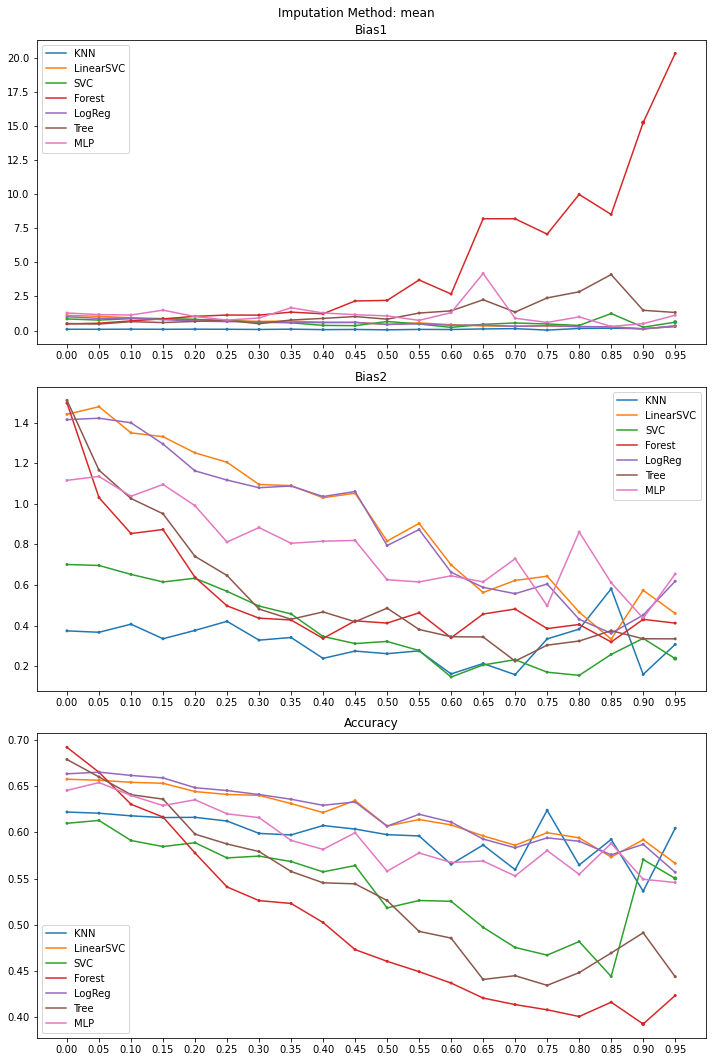

In [16]:
plot_result("mean", "ratio_mean.png")

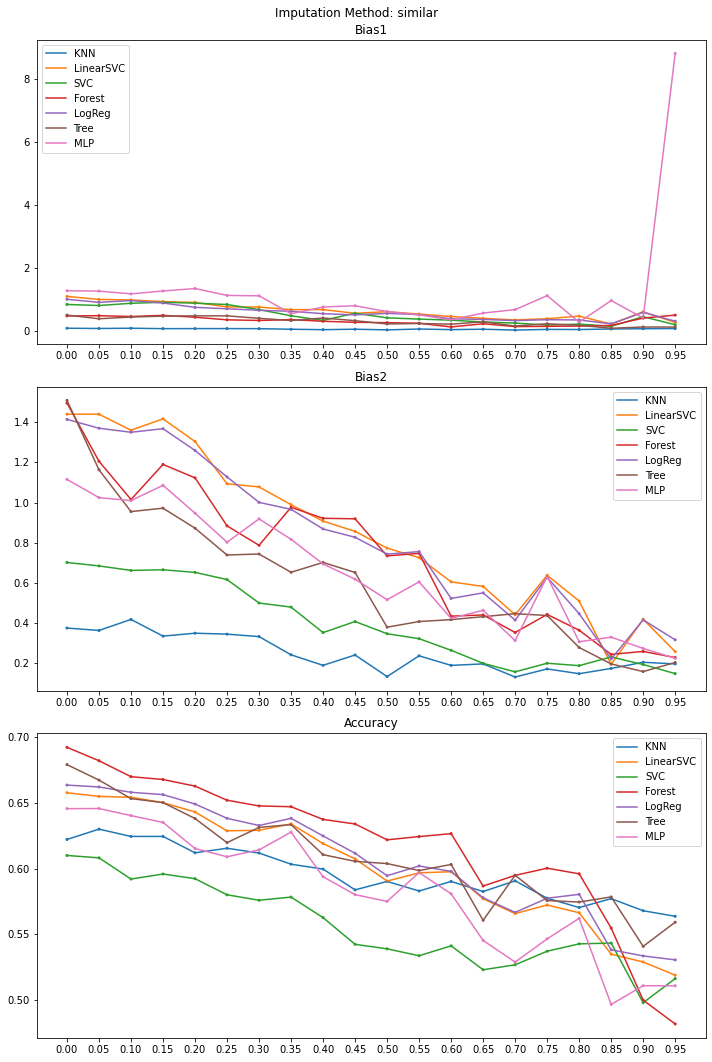

In [17]:
plot_result("similar", "ratio_similar.png")

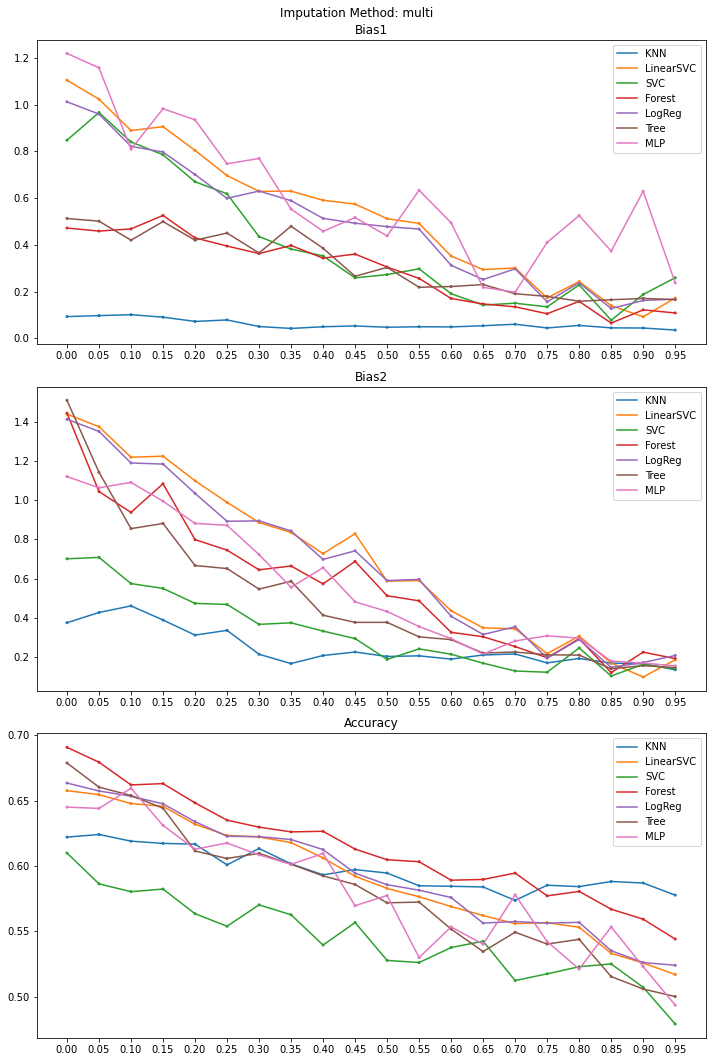

In [18]:
plot_result("multi", "ratio_multi.png")